# 1. Data Collection

In [1]:
#import necessary Library
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Load data

In [2]:
# Load the dataset
file_path = '../data/MachineLearningRating_v3.txt'
df = pd.read_csv(file_path, sep='|')

Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
df.head()

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0


# 2. Data preprocessing

Handling missing value

In [4]:
# Calculate the percentage of missing values for each column
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Combine the missing values and percentages into a single DataFrame
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

# Filter out columns with missing values only
missing_data = missing_data[missing_data['Missing Values'] > 0]

# Display the missing values and their percentage
print(missing_data.sort_values(by='Percentage', ascending=False))


                         Missing Values  Percentage
NumberOfVehiclesInFleet         1000098  100.000000
CrossBorder                      999400   99.930207
CustomValueEstimate              779642   77.956560
Converted                        641901   64.183810
Rebuilt                          641901   64.183810
WrittenOff                       641901   64.183810
NewVehicle                       153295   15.327998
Bank                             145961   14.594670
AccountType                       40232    4.022806
Gender                             9536    0.953507
MaritalStatus                      8259    0.825819
Cylinders                           552    0.055195
cubiccapacity                       552    0.055195
kilowatts                           552    0.055195
NumberOfDoors                       552    0.055195
VehicleIntroDate                    552    0.055195
Model                               552    0.055195
make                                552    0.055195
VehicleType 

In [5]:
# drop the columens that have more than 50% missing values
cols_to_drop = ['NumberOfVehiclesInFleet', 'CrossBorder', 'CustomValueEstimate', 
                'Converted', 'Rebuilt', 'WrittenOff']
df = df.drop(columns=cols_to_drop)


# Impute missing values for categorical columns with the mode
categorical_cols = ['NewVehicle', 'AccountType', 'Bank', 'VehicleType', 
                    'make', 'Model', 'mmcode', 'bodytype', 'Gender', 'MaritalStatus']

for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




In [6]:
# Impute missing values for numerical columns with the mean
numerical_cols = ['cubiccapacity', 'kilowatts', 'Cylinders', 'NumberOfDoors']
for col in numerical_cols:
    df[col].fillna(df[col].mean(), inplace=True)

# Drop rows with missing values in the 'CapitalOutstanding' column
df.dropna(subset=['CapitalOutstanding'], inplace=True)

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




In [7]:
# Handle missing values for 'VehicleIntroDate'
default_date = '2014-01-01-00:00:00'
df['VehicleIntroDate'].fillna(default_date, inplace=True)
df['VehicleIntroDate'] = pd.to_datetime(df['VehicleIntroDate'])

# Verify if there are any remaining missing values
print(df.isnull().sum())

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


UnderwrittenCoverID         0
PolicyID                    0
TransactionMonth            0
IsVATRegistered             0
Citizenship                 0
LegalType                   0
Title                       0
Language                    0
Bank                        0
AccountType                 0
MaritalStatus               0
Gender                      0
Country                     0
Province                    0
PostalCode                  0
MainCrestaZone              0
SubCrestaZone               0
ItemType                    0
mmcode                      0
VehicleType                 0
RegistrationYear            0
make                        0
Model                       0
Cylinders                   0
cubiccapacity               0
kilowatts                   0
bodytype                    0
NumberOfDoors               0
VehicleIntroDate            0
AlarmImmobiliser            0
TrackingDevice              0
CapitalOutstanding          0
NewVehicle                  0
SumInsured

Feature Engineering
Create new features that might be relevant for prediction.

In [8]:
# Calculate the percentage of missing values for each column
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Combine the missing values and percentages into a single DataFrame
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

# Filter out columns with missing values only
missing_data = missing_data[missing_data['Missing Values'] > 0]

# Display the missing values and their percentage
print(missing_data.sort_values(by='Percentage', ascending=False))


Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


In [9]:
# Example feature engineering
df['PremiumPerClaim'] = df['TotalPremium'] / (df['TotalClaims'] + 1)  # Avoid division by zero
df['ClaimRatio'] = df['TotalClaims'] / (df['TotalPremium'] + 1)  # Avoid division by zero


In [10]:
# Print the first few rows to check the new columns
print("DataFrame after feature engineering:")
df.head()

DataFrame after feature engineering:


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims,PremiumPerClaim,ClaimRatio
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,21.929825,0.0
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,21.929825,0.0
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0,0.000000,0.0
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0,512.848070,0.0
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0,0.000000,0.0


Encoding Categorical Data
Convert categorical data into numeric format using one-hot encoding.

In [11]:
# Convert 'TransactionMonth' and 'VehicleIntroDate' to datetime
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'], errors='coerce')
df['VehicleIntroDate'] = pd.to_datetime(df['VehicleIntroDate'], errors='coerce')

# Extract features from datetime columns
df['TransactionMonth_Year'] = df['TransactionMonth'].dt.year
df['TransactionMonth_Month'] = df['TransactionMonth'].dt.month
df['VehicleIntroDate_Year'] = df['VehicleIntroDate'].dt.year
df['VehicleIntroDate_Month'] = df['VehicleIntroDate'].dt.month
df = df.drop(columns=['TransactionMonth', 'VehicleIntroDate'])


In [12]:
# One-Hot Encoding
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.head()

,UnderwrittenCoverID,PolicyID,IsVATRegistered,PostalCode,mmcode,RegistrationYear,Cylinders,cubiccapacity,kilowatts,NumberOfDoors,...,CoverGroup_Standalone passenger liability,CoverGroup_Third Party Only,CoverGroup_Trailer,Section_Motor Comprehensive,Section_Optional Extended Covers,Section_Standalone passenger liability,"Section_Third party or third party, fire and theft only",Product_Mobility Commercial Cover: Monthly,Product_Mobility Metered Taxis: Monthly,Product_Standalone Passenger Liability
0,145249,12827,True,1459,44069150.0,2004,6.0,2597.0,130.0,4.0,...,False,False,False,True,False,False,False,False,True,False
1,145249,12827,True,1459,44069150.0,2004,6.0,2597.0,130.0,4.0,...,False,False,False,True,False,False,False,False,True,False
2,145249,12827,True,1459,44069150.0,2004,6.0,2597.0,130.0,4.0,...,False,False,False,True,False,False,False,False,True,False
3,145255,12827,True,1459,44069150.0,2004,6.0,2597.0,130.0,4.0,...,False,False,False,True,False,False,False,False,True,False
4,145255,12827,True,1459,44069150.0,2004,6.0,2597.0,130.0,4.0,...,False,False,False,True,False,False,False,False,True,False


## 3. Train-Test Split

In [13]:

# Define target and features
X = df_encoded.drop(['TotalPremium', 'TotalClaims'], axis=1)
y_premium = df_encoded['TotalPremium']
y_claims = df_encoded['TotalClaims']

In [14]:
# Split data for TotalPremium
X_train_premium, X_test_premium, y_train_premium, y_test_premium = train_test_split(X, y_premium, test_size=0.2, random_state=42)

# Split data for TotalClaims
X_train_claims, X_test_claims, y_train_claims, y_test_claims = train_test_split(X, y_claims, test_size=0.2, random_state=42)


## 4. Model Building

#### 4.1 Decision Tree

In [15]:
# Model for TotalPremium
model_premium_dt = DecisionTreeRegressor()
model_premium_dt.fit(X_train_premium, y_train_premium)
y_pred_premium_dt = model_premium_dt.predict(X_test_premium)

In [16]:
# Calculate Metrics
mse_premium_dt = mean_squared_error(y_test_premium, y_pred_premium_dt)
mae_premium_dt = mean_absolute_error(y_test_premium, y_pred_premium_dt)
r2_premium_dt = r2_score(y_test_premium, y_pred_premium_dt)
# Evaluate
print(f"TotalPremium - MSE: {mean_squared_error(y_test_premium, y_pred_premium_dt)}, R^2: {r2_score(y_test_premium, y_pred_premium_dt)}, MAE: {mean_absolute_error(y_test_premium, y_pred_premium_dt)}")


TotalPremium - MSE: 8334.26457688738, R^2: 0.8190966894090738, MAE: 0.23700229005598608


In [17]:
# Model for TotalClaims
model_claims_dt = DecisionTreeRegressor()
model_claims_dt.fit(X_train_claims, y_train_claims)
y_pred_claims_dt = model_claims_dt.predict(X_test_claims)

In [18]:


mse_claims_dt = mean_squared_error(y_test_claims, y_pred_claims_dt)
mae_claims_dt = mean_absolute_error(y_test_claims, y_pred_claims_dt)
r2_claims_dt = r2_score(y_test_claims, y_pred_claims_dt)
print(f"TotalClaims - MSE: {mean_squared_error(y_test_claims, y_pred_claims_dt)}, R^2: {r2_score(y_test_claims, y_pred_claims_dt)}, MAE: {mean_absolute_error(y_test_claims, y_pred_claims_dt)}")



TotalClaims - MSE: 654721.2151717867, R^2: 0.8855147213686871, MAE: 10.388304894949117


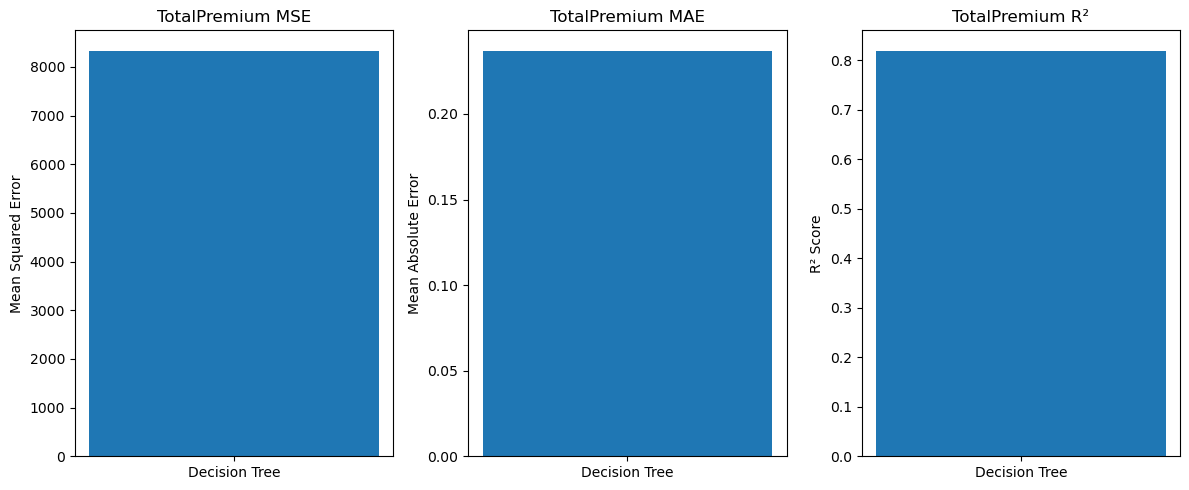

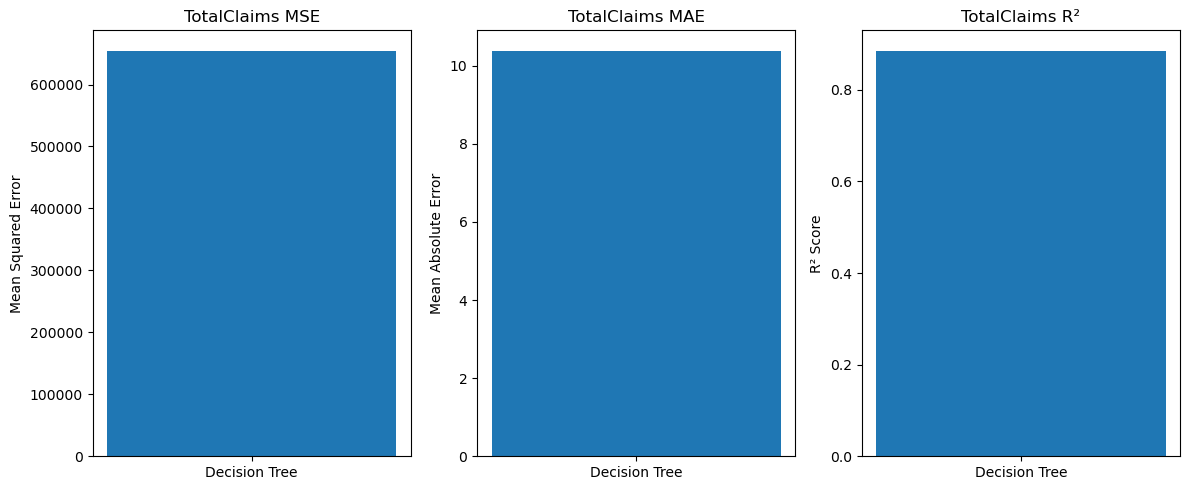

In [19]:
# Plot for TotalPremium
plt.figure(figsize=(12, 5))

# MSE
plt.subplot(1, 3, 1)
plt.bar(['Decision Tree'], [mse_premium_dt])
plt.title('TotalPremium MSE')
plt.ylabel('Mean Squared Error')

# MAE
plt.subplot(1, 3, 2)
plt.bar(['Decision Tree'], [mae_premium_dt])
plt.title('TotalPremium MAE')
plt.ylabel('Mean Absolute Error')

# R²
plt.subplot(1, 3, 3)
plt.bar(['Decision Tree'], [r2_premium_dt])
plt.title('TotalPremium R²')
plt.ylabel('R² Score')

plt.tight_layout()
plt.show()

# Plot for TotalClaims
plt.figure(figsize=(12, 5))

# MSE
plt.subplot(1, 3, 1)
plt.bar(['Decision Tree'], [mse_claims_dt])
plt.title('TotalClaims MSE')
plt.ylabel('Mean Squared Error')

# MAE
plt.subplot(1, 3, 2)
plt.bar(['Decision Tree'], [mae_claims_dt])
plt.title('TotalClaims MAE')
plt.ylabel('Mean Absolute Error')

# R²
plt.subplot(1, 3, 3)
plt.bar(['Decision Tree'], [r2_claims_dt])
plt.title('TotalClaims R²')
plt.ylabel('R² Score')

plt.tight_layout()
plt.show()

### 4.2. Random Forest

In [14]:
# Model for TotalPremium
model_premium_rf = RandomForestRegressor()
model_premium_rf.fit(X_train_premium, y_train_premium)
y_pred_premium_rf = model_premium_rf.predict(X_test_premium)

In [15]:
# Calculate Metrics
mse_premium_rf = mean_squared_error(y_test_premium, y_pred_premium_rf)
mae_premium_rf = mean_absolute_error(y_test_premium, y_pred_premium_rf)
r2_premium_rf = r2_score(y_test_premium, y_pred_premium_rf)
# Evaluate
print(f"TotalPremium - MSE: {mean_squared_error(y_test_premium, y_pred_premium_rf)}, R^2: {r2_score(y_test_premium, y_pred_premium_rf)}, MAE: {mean_absolute_error(y_test_premium, y_pred_premium_rf)}")

TotalPremium - MSE: 4453.750574790063, R^2: 0.903327016308058, MAE: 0.1878067160627778


In [17]:
# Model for TotalClaims
model_claims_rf = RandomForestRegressor()
model_claims_rf.fit(X_train_claims, y_train_claims)
y_pred_claims_rf = model_claims_rf.predict(X_test_claims)

In [18]:
#calculate

mse_claims_rf = mean_squared_error(y_test_claims, y_pred_claims_rf)
mae_claims_rf = mean_absolute_error(y_test_claims, y_pred_claims_rf)
r2_claims_rf = r2_score(y_test_claims, y_pred_claims_rf)

#evaluate
print(f"TotalClaims - MSE: {mean_squared_error(y_test_claims, y_pred_claims_rf)}, R^2: {r2_score(y_test_claims, y_pred_claims_rf)}, MAE: {mean_absolute_error(y_test_claims, y_pred_claims_rf)}")

TotalClaims - MSE: 251016.3364587554, R^2: 0.9561070046997763, MAE: 7.659981304799349


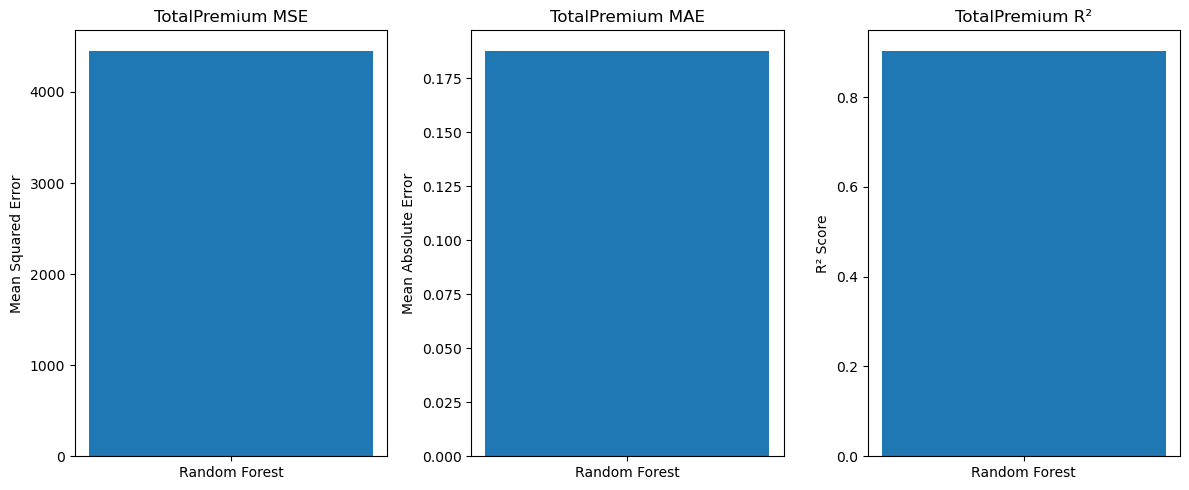

In [16]:
# Plot for TotalPremium
plt.figure(figsize=(12, 5))

# MSE
plt.subplot(1, 3, 1)
plt.bar(['Random Forest'], [mse_premium_rf])
plt.title('TotalPremium MSE')
plt.ylabel('Mean Squared Error')

# MAE
plt.subplot(1, 3, 2)
plt.bar(['Random Forest'], [mae_premium_rf])
plt.title('TotalPremium MAE')
plt.ylabel('Mean Absolute Error')

# R²
plt.subplot(1, 3, 3)
plt.bar(['Random Forest'], [r2_premium_rf])
plt.title('TotalPremium R²')
plt.ylabel('R² Score')

plt.tight_layout()
plt.show()


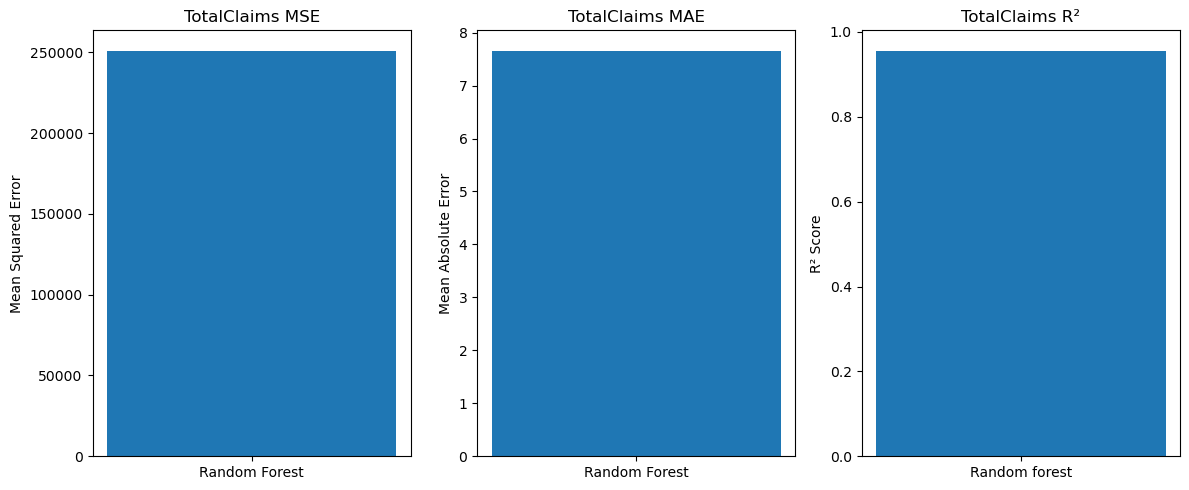

In [19]:
# Plot for TotalClaims
plt.figure(figsize=(12, 5))

# MSE
plt.subplot(1, 3, 1)
plt.bar(['Random Forest'], [mse_claims_rf])
plt.title('TotalClaims MSE')
plt.ylabel('Mean Squared Error')

# MAE
plt.subplot(1, 3, 2)
plt.bar(['Random Forest'], [mae_claims_rf])
plt.title('TotalClaims MAE')
plt.ylabel('Mean Absolute Error')

# R²
plt.subplot(1, 3, 3)
plt.bar(['Random forest'], [r2_claims_rf])
plt.title('TotalClaims R²')
plt.ylabel('R² Score')

plt.tight_layout()
plt.show()

### XGBoost

In [ ]:
# Model for TotalPremium
model_premium_xgb = xgb.XGBRegressor()
model_premium_xgb.fit(X_train_premium, y_train_premium)
y_pred_premium_xgb = model_premium_xgb.predict(X_test_premium)

In [ ]:
# Calculate Metrics
mse_premium_xgb = mean_squared_error(y_test_premium, y_pred_premium_xgb)
mae_premium_xgb = mean_absolute_error(y_test_premium, y_pred_premium_xgb)
r2_premium_xgb = r2_score(y_test_premium, y_pred_premium_xgb)
# Evaluate
print(f"TotalPremium - MSE: {mean_squared_error(y_test_premium, y_pred_premium_xgb)}, R^2: {r2_score(y_test_premium, y_pred_premium_xgb)}, MAE: {mean_absolute_error(y_test_premium, y_pred_premium_xgb)}")

In [ ]:
# Model for TotalClaims
model_claims_xgb = xgb.XGBRegressor()
model_claims_xgb.fit(X_train_claims, y_train_claims)
y_pred_claims_xgb = model_claims_xgb.predict(X_test_claims)

In [ ]:
#calculate

mse_claims_xgb = mean_squared_error(y_test_claims, y_pred_claims_xgb)
mae_claims_xgb = mean_absolute_error(y_test_claims, y_pred_claims_xgb)
r2_claims_xgb = r2_score(y_test_claims, y_pred_claims_xgb)

#evaluate
print(f"TotalClaims - MSE: {mean_squared_error(y_test_claims, y_pred_claims_xgb)}, R^2: {r2_score(y_test_claims, y_pred_claims_xgb)}, MAE: {mean_absolute_error(y_test_claims, y_pred_claims_xgb)}")


In [ ]:
# Plot for TotalPremium
plt.figure(figsize=(12, 5))

# MSE
plt.subplot(1, 3, 1)
plt.bar(['XGBoost'], [mse_premium_xgb])
plt.title('TotalPremium MSE')
plt.ylabel('Mean Squared Error')

# MAE
plt.subplot(1, 3, 2)
plt.bar(['XGBoost'], [mae_premium_xgb])
plt.title('TotalPremium MAE')
plt.ylabel('Mean Absolute Error')

# R²
plt.subplot(1, 3, 3)
plt.bar(['XGBoost'], [r2_premium_xgb])
plt.title('TotalPremium R²')
plt.ylabel('R² Score')

plt.tight_layout()
plt.show()

# Plot for TotalClaims
plt.figure(figsize=(12, 5))

# MSE
plt.subplot(1, 3, 1)
plt.bar(['XGBoost'], [mse_claims_xgb])
plt.title('TotalClaims MSE')
plt.ylabel('Mean Squared Error')

# MAE
plt.subplot(1, 3, 2)
plt.bar(['XGBoost'], [mae_claims_xgb])
plt.title('TotalClaims MAE')
plt.ylabel('Mean Absolute Error')

# R²
plt.subplot(1, 3, 3)
plt.bar(['XGBoost'], [r2_claims_xgb])
plt.title('TotalClaims R²')
plt.ylabel('R² Score')

plt.tight_layout()
plt.show()

### Linear Regression

In [ ]:
# Model for TotalPremium
model_premium_lr = LinearRegression()
model_premium_lr.fit(X_train_premium, y_train_premium)
y_pred_premium_lr = model_premium_lr.predict(X_test_premium)

In [ ]:
# Calculate Metrics
mse_premium_lr = mean_squared_error(y_test_premium, y_pred_premium_lr)
mae_premium_lr = mean_absolute_error(y_test_premium, y_pred_premium_lr)
r2_premium_lr = r2_score(y_test_premium, y_pred_premium_lr)
# Evaluate
print(f"TotalPremium - MSE: {mean_squared_error(y_test_premium, y_pred_premium_lr)}, R^2: {r2_score(y_test_premium, y_pred_premium_lr)}, MAE: {mean_absolute_error(y_test_premium, y_pred_premium_lr)}")

In [ ]:
# Model for TotalClaims
model_claims_lr = LinearRegression()
model_claims_lr.fit(X_train_claims, y_train_claims)
y_pred_claims_lr = model_claims_lr.predict(X_test_claims)

In [ ]:
#calculate

mse_claims_lr = mean_squared_error(y_test_claims, y_pred_claims_lr)
mae_claims_lr = mean_absolute_error(y_test_claims, y_pred_claims_lr)
r2_claims_lr = r2_score(y_test_claims, y_pred_claims_lr)

#evaluate
print(f"TotalClaims - MSE: {mean_squared_error(y_test_claims, y_pred_claims_lr)}, R^2: {r2_score(y_test_claims, y_pred_claims_lr)}, MAE: {mean_absolute_error(y_test_claims, y_pred_claims_lr)}")


In [ ]:
# Plot for TotalPremium
plt.figure(figsize=(12, 5))

# MSE
plt.subplot(1, 3, 1)
plt.bar(['Leaner Regression'], [mse_premium_lr])
plt.title('TotalPremium MSE')
plt.ylabel('Mean Squared Error')

# MAE
plt.subplot(1, 3, 2)
plt.bar(['Leaner Regression'], [mae_premium_lr])
plt.title('TotalPremium MAE')
plt.ylabel('Mean Absolute Error')

# R²
plt.subplot(1, 3, 3)
plt.bar(['Leaner Regression'], [r2_premium_lr])
plt.title('TotalPremium R²')
plt.ylabel('R² Score')

plt.tight_layout()
plt.show()

# Plot for TotalClaims
plt.figure(figsize=(12, 5))

# MSE
plt.subplot(1, 3, 1)
plt.bar(['Leaner Regression'], [mse_claims_lr])
plt.title('TotalClaims MSE')
plt.ylabel('Mean Squared Error')

# MAE
plt.subplot(1, 3, 2)
plt.bar(['Leaner Regression'], [mae_claims_lr])
plt.title('TotalClaims MAE')
plt.ylabel('Mean Absolute Error')

# R²
plt.subplot(1, 3, 3)
plt.bar(['Leaner Regression'], [r2_claims_lr])
plt.title('TotalClaims R²')
plt.ylabel('R² Score')

plt.tight_layout()
plt.show()

## Feature Importance Analysis

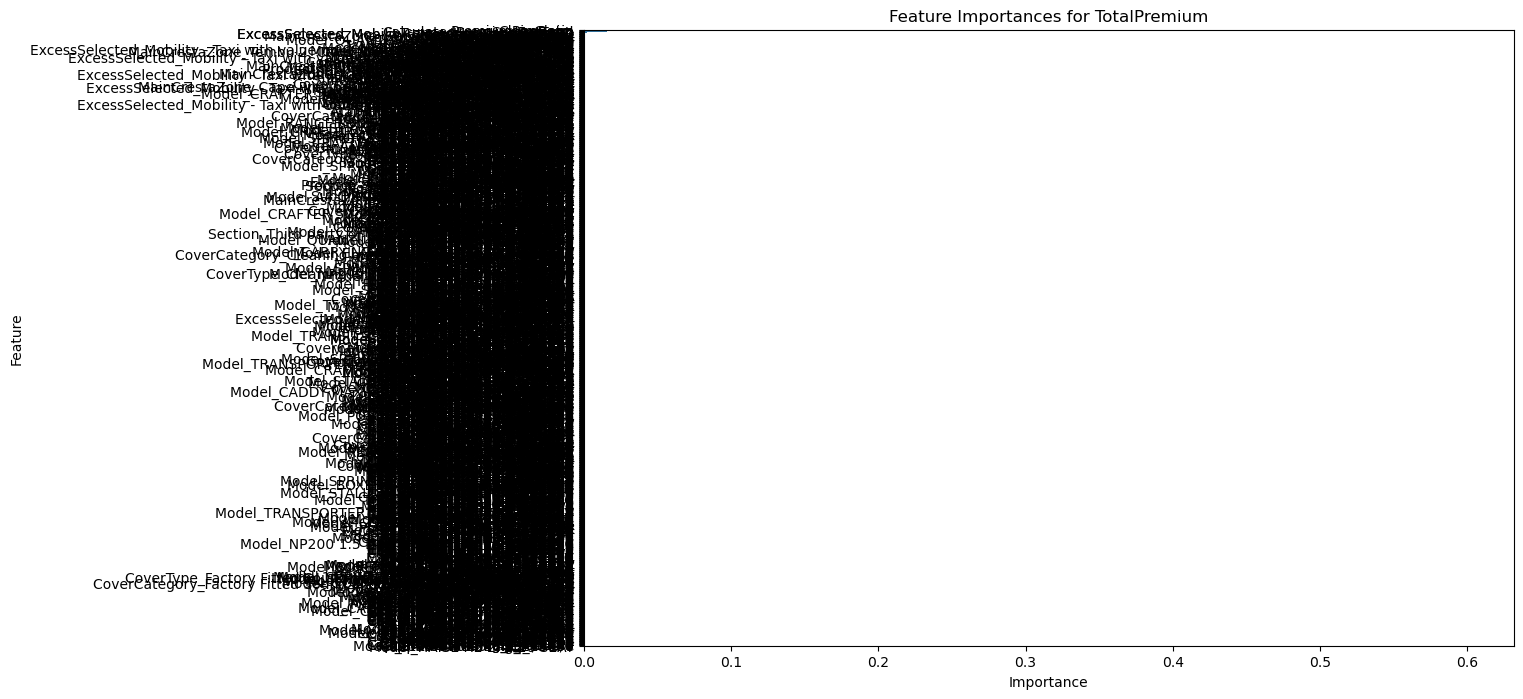

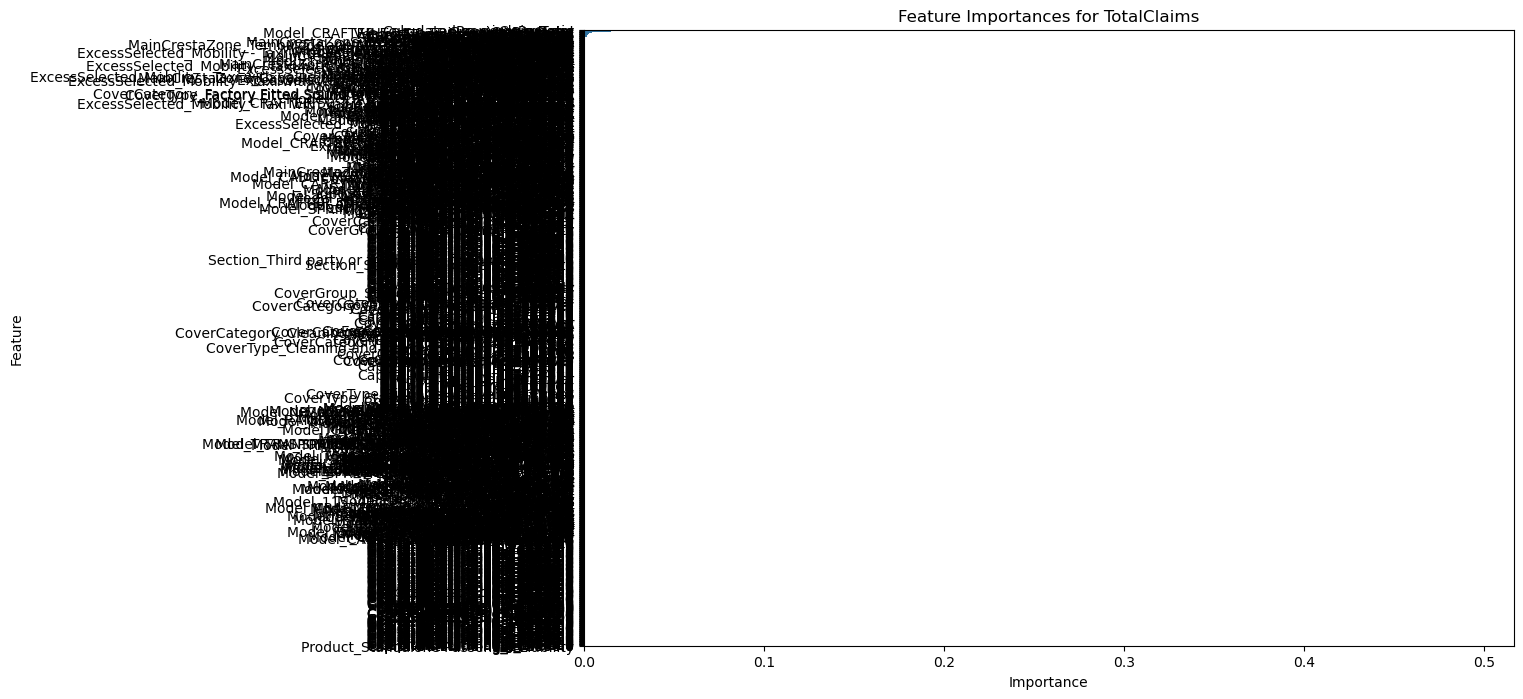

In [20]:
importances_premium = model_premium_rf.feature_importances_
importances_claims = model_claims_rf.feature_importances_

# Create DataFrames for feature importances
features = X.columns
importance_df_premium = pd.DataFrame({'Feature': features, 'Importance': importances_premium})
importance_df_claims = pd.DataFrame({'Feature': features, 'Importance': importances_claims})

# Sort and plot feature importances
importance_df_premium = importance_df_premium.sort_values(by='Importance', ascending=False)
importance_df_claims = importance_df_claims.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(30, 120))
sns.barplot(x='Importance', y='Feature', data=importance_df_premium)
plt.title('Feature Importances for TotalPremium')
plt.show()

plt.figure(figsize=(30, 120))
sns.barplot(x='Importance', y='Feature', data=importance_df_claims)
plt.title('Feature Importances for TotalClaims')
plt.show()


## Model Interpretability

In [21]:
import shap

# SHAP values for XGBoost model
explainer_premium = shap.Explainer(model_premium_rf)
shap_values_premium = explainer_premium(X_test_premium)
shap.summary_plot(shap_values_premium, X_test_premium)

explainer_claims = shap.Explainer(model_claims_rf)
shap_values_claims = explainer_claims(X_test_claims)
shap.summary_plot(shap_values_claims, X_test_claims)


### Reporting and Comparison

In [ ]:
# Create a summary of model performance
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'TotalPremium_MSE': [
        mean_squared_error(y_test_premium, y_pred_premium_lr),
        mean_squared_error(y_test_premium, y_pred_premium_dt),
        mean_squared_error(y_test_premium, y_pred_premium_rf),
        mean_squared_error(y_test_premium, y_pred_premium_xgb)
    ],
    'TotalClaims_MSE': [
        mean_squared_error(y_test_claims, y_pred_claims_lr),
        mean_squared_error(y_test_claims, y_pred_claims_dt),
        mean_squared_error(y_test_claims, y_pred_claims_rf),
        mean_squared_error(y_test_claims, y_pred_claims_xgb)
    ],
    'TotalPremium_R2': [
        r2_score(y_test_premium, y_pred_premium_lr),
        r2_score(y_test_premium, y_pred_premium_dt),
        r2_score(y_test_premium, y_pred_premium_rf),
        r2_score(y_test_premium, y_pred_premium_xgb)
    ],
    'TotalClaims_R2': [
        r2_score(y_test_claims, y_pred_claims_lr),
        r2_score(y_test_claims, y_pred_claims_dt),
        r2_score(y_test_claims, y_pred_claims_rf),
        r2_score(y_test_claims, y_pred_claims_xgb)
    ]
})


In [ ]:
print(results)